In [2]:
####### dropout resnet18 vs without dropout
#### 
import torch
import sys
sys.path.append("..")
import numpy as np

TAR_PATH = "/home/yifan/Exp/Mutation/drop_channel/0.2/experiment1"
REF_PATH = "/home/yifan/dataset/clean/pairflip/cifar10/0"

ENCODER_DIMS=[512,256,256,256,256,2]
DECODER_DIMS= [2,256,256,256,256,512]
VIS_MODEL_NAME = 'vis2'

DEVICE='cuda:1'
########## initulize reference data and target data
from AlignVis.DataInit import DataInit
REF_EPOCH = 200
TAR_EPOCH = 200
tar_datainit = DataInit(TAR_PATH,TAR_PATH,TAR_EPOCH,DEVICE)
ref_datainit = DataInit(REF_PATH,REF_PATH,REF_EPOCH,DEVICE)

ref_model, ref_provider, ref_train_data, ref_prediction, ref_prediction_res, ref_scores = ref_datainit.getData()
tar_model, tar_provider, tar_train_data, tar_prediction, tar_prediction_res, tar_scores = tar_datainit.getData()


from AlignVis.ReferenceGenerator import ReferenceGenerator
gen = ReferenceGenerator(ref_provider=ref_provider, tar_provider=tar_provider,REF_EPOCH=REF_EPOCH,TAR_EPOCH=TAR_EPOCH,ref_model=ref_model,tar_model=tar_model,DEVICE=DEVICE)

absolute_alignment_indicates,predict_label_diff_indicates,predict_confidence_Diff_indicates,high_distance_indicates = gen.subsetClassify(18,0.8,0.3,0.05)


from AlignVis_Visualizer.visualizer import visualizer
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

I = np.eye(512)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
vis = visualizer(ref_provider, I,I, np.dot(ref_provider.train_representation(TAR_EPOCH),I), projector, 200,[0,1],'tab10')


NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 8277.75it/s]


NET resnet18_with_mutation
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 8190.91it/s]


absolute alignment indicates number: 146 label diff indicates number: 35 confidence diff indicates number: 41 high distance number: 11


In [64]:
import os
from AlignVisAutoEncoder.autoencoder import SimpleAutoencoder
autoencoder = SimpleAutoencoder(512,512)
checkpoint = torch.load(os.path.join(TAR_PATH,"pre_autoencoder.npy"))
autoencoder.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [71]:
import os
from AlignVisAutoEncoder.autoencoder import SimpleAutoencoder
autoencoder = SimpleAutoencoder(512,512)
checkpoint = torch.load(os.path.join(TAR_PATH,"pre_autoencoder_withborder.npy"))
autoencoder.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [4]:
import os
ref_border_path = os.path.join(TAR_PATH,"Model", "Epoch_{:d}".format(TAR_EPOCH),
                                          "aligned_ref_border.npy")
tar_border_path = os.path.join(TAR_PATH,"Model", "Epoch_{:d}".format(TAR_EPOCH),
                                          "aligned_tar_border.npy")
if os.path.exists(ref_border_path) and os.path.exists(tar_border_path):
    print("aaa")
    ref_border_centers_loc = os.path.join(TAR_PATH,"Model", "Epoch_{:d}".format(TAR_EPOCH),
                                          "aligned_ref_border.npy")
    ref_features = np.load(ref_border_centers_loc).squeeze()
    tar_border_centers_loc = os.path.join(TAR_PATH,"Model", "Epoch_{:d}".format(TAR_EPOCH),
                                          "aligned_tar_border.npy")
    tar_features = np.load(tar_border_centers_loc).squeeze()

aaa


In [70]:
from AlignVis_eval.AlignEval import Evaluator
eval = Evaluator(projector,ref_provider,tar_provider,REF_EPOCH,TAR_EPOCH)
eval.eval_boundary_nn_ref_in_ref(ref_features, 15)

#train# boundary preserving: 1.52/15 in epoch 200


1.51616

In [148]:
def eval_boundary_align_sensitivity(autoencoder, tar_b_features, ref_b_features,val=0.15):
        ############## init ###################
        #init target
        print("123")
        tar_b_pred = tar_provider.get_pred(TAR_EPOCH, tar_b_features)
        tar_b_pred = tar_b_pred + 1e-8
        tar_sort_preds = np.sort(tar_b_pred, axis=1)
        tar_diff = (tar_sort_preds[:, -1] - tar_sort_preds[:, -2]) / (tar_sort_preds[:, -1] - tar_sort_preds[:, 0])
        tar_border = np.zeros(len(tar_diff), dtype=np.uint8) + 0.05
        tar_border[tar_diff < 0.15] = 1

        #init reference
        ref_b_pred = ref_provider.get_pred(REF_EPOCH, ref_b_features)
        ref_b_pred = ref_b_pred + 1e-8
        ref_sort_preds = np.sort(ref_b_pred, axis=1)
        ref_diff = (ref_sort_preds[:, -1] - ref_sort_preds[:, -2]) / (ref_sort_preds[:, -1] - ref_sort_preds[:, 0])
        ref_border = np.zeros(len(ref_diff), dtype=np.uint8) + 0.05
        ref_border[ref_diff < 0.15] = 1
        
        ##### get all boundary list
        all_boundary_list = []
        
        for i in range(len(ref_border)):
            if ref_border[i] == 1 and tar_border[i] == 1:
                all_boundary_list.append(i)
        print(len(all_boundary_list))
        #### get ref low dimensional border
        ref_b_embedding = projector.batch_project(REF_EPOCH, ref_b_features)
        ref_b_inv = projector.batch_inverse(REF_EPOCH,ref_b_embedding)
        ref_b_pred_l = ref_provider.get_pred(REF_EPOCH, ref_b_inv)
        ref_b_pred_l = ref_b_pred_l  + 1e-8
        ref_sort_preds_l  = np.sort(ref_b_pred_l , axis=1)
        ref_diff_l  = (ref_sort_preds_l[:, -1] - ref_sort_preds_l[:, -2]) / (ref_sort_preds_l[:, -1] - ref_sort_preds_l[:, 0])
        ref_border_l = np.zeros(len(ref_diff_l), dtype=np.uint8) + 0.05
        ref_border_l[ref_diff_l < val] = 1
        
        #### get target low dimensional border
        tar_b_embedding = projector.batch_project(REF_EPOCH, autoencoder.encoder(torch.Tensor(ref_b_features)).detach().numpy())
        tar_b_inv = projector.batch_inverse(REF_EPOCH,tar_b_embedding)
        tar_b_inv = autoencoder.decoder(torch.Tensor(tar_b_inv)).detach().numpy()
        tar_b_pred_l = tar_provider.get_pred(REF_EPOCH, tar_b_inv)
        tar_b_pred_l = tar_b_pred_l  + 1e-8
        tar_sort_preds_l  = np.sort(tar_b_pred_l , axis=1)
        tar_diff_l  = (tar_sort_preds_l[:, -1] - tar_sort_preds_l[:, -2]) / (tar_sort_preds_l[:, -1] - tar_sort_preds_l[:, 0])
        tar_border_l = np.zeros(len(tar_diff_l), dtype=np.uint8) + 0.05
        tar_border_l[tar_diff_l < val] = 1

        all_boundary_list_l = []
       
        all_change = []
        all_change_l=[]
        neeee = []
        for i in range(len(ref_border)):
            ##### low dimension all border
            if ref_border_l[i] == 1 and tar_border_l[i] == 1:
                all_boundary_list_l.append(i)
            if ref_border[i] != tar_border[i]:
                 all_change.append(i)
            if ref_border[i] != tar_border[i] and tar_border_l[i] == tar_border[i]:
                 all_change_l.append(i)
            if ref_border_l[i] == 1 and tar_border[i] != 1:
                 neeee.append(i)
                 
                 
           


        print("boundary sample preserving{}/{}".format(len(all_boundary_list_l),len(all_boundary_list)))
        print("boundary change preserving{}/{}".format(len(all_change_l),len(all_change)))
        return all_boundary_list,all_boundary_list_l,all_change,all_change_l,neeee
       
all_boundary_list,all_boundary_list_l,all_change,all_change_l,sss = eval_boundary_align_sensitivity(autoencoder,np.concatenate((tar_train_data,tar_features),axis=0), np.concatenate((ref_train_data,ref_features),axis=0))      

123


100%|██████████| 260/260 [00:00<00:00, 7473.10it/s]

2041



100%|██████████| 260/260 [00:00<00:00, 8232.38it/s]

boundary sample preserving637/2041
boundary change preserving346/817


In [149]:
len(sss)

2318

In [24]:
all_boundary_list,all_boundary_list_l,all_change,all_change_l = eval_boundary_align_sensitivity(autoencoder,tar_train_data, ref_train_data,0.15)  

123


100%|██████████| 250/250 [00:00<00:00, 8136.44it/s]

41



100%|██████████| 250/250 [00:00<00:00, 8493.52it/s]

boundary sample preserving590/41
boundary change preserving337/817


In [25]:
len(all_boundary_list_l)

590

In [22]:
tar_pred_softmax = tar_provider.get_pred(200,tar_train_data[all_boundary_list_l])
ref_pred_softmax = ref_provider.get_pred(200,ref_train_data[all_boundary_list_l])
#### find long distance move set and short distance move by calculate softmax res mean absolute error and top 2 classes
longDistanceMove = []
shortDistanceMove = []
tar_top_classes = np.argsort(tar_pred_softmax, axis=1)[:, ::-1][:, :2]
ref_top_classes = np.argsort(ref_pred_softmax, axis=1)[:, ::-1][:, :2]

100%|██████████| 2/2 [00:00<00:00, 6388.89it/s]


In [18]:
tar_top_classes

array([[3, 5],
       [5, 3],
       [3, 4],
       [9, 0],
       [3, 7],
       [5, 4],
       [7, 4],
       [6, 8],
       [3, 1],
       [2, 4],
       [3, 7],
       [6, 0],
       [3, 7],
       [5, 2],
       [5, 9],
       [3, 6],
       [3, 1],
       [5, 4],
       [9, 1],
       [5, 4],
       [3, 2],
       [7, 5],
       [5, 7],
       [8, 0],
       [9, 0],
       [3, 5],
       [0, 1],
       [5, 6],
       [4, 2],
       [3, 6],
       [5, 7],
       [3, 7],
       [0, 2],
       [6, 7],
       [3, 2],
       [8, 2],
       [3, 5],
       [4, 5],
       [3, 4],
       [4, 5],
       [5, 3],
       [5, 7],
       [3, 2],
       [3, 4],
       [2, 0],
       [2, 0],
       [3, 2],
       [5, 3],
       [3, 6],
       [5, 3],
       [5, 4],
       [0, 9],
       [3, 5],
       [3, 2],
       [3, 8],
       [3, 0],
       [3, 5],
       [3, 7],
       [2, 6],
       [5, 3],
       [8, 0],
       [3, 5],
       [6, 3],
       [5, 7],
       [0, 3],
       [9, 1],
       [6,

In [28]:
same_boundary = []
diff_boundary = []

for i in range(len(ref_top_classes)):
    if (tar_top_classes[i][0] == ref_top_classes[i][0] and tar_top_classes[i][1] == ref_top_classes[i][1]) or(tar_top_classes[i][1] == ref_top_classes[i][0] and tar_top_classes[i][0] == ref_top_classes[i][1]) :
        same_boundary.append(all_boundary_list_l[i])
    else:
        diff_boundary.append(all_boundary_list_l[i])



In [29]:
same_boundary

[38,
 50,
 231,
 618,
 742,
 1488,
 1496,
 1569,
 1717,
 1841,
 1879,
 1919,
 1951,
 1991,
 2071,
 2457,
 2884,
 3177,
 3265,
 3307,
 3576,
 3751,
 3803,
 3935,
 4462,
 4486,
 4808,
 4847,
 5260,
 5290,
 5512,
 5534,
 5733,
 5827,
 6060,
 6102,
 6345,
 6602,
 6939,
 7106,
 7304,
 7539,
 7615,
 7781,
 8934,
 9710,
 9917,
 10217,
 10221,
 10319,
 10341,
 10454,
 10464,
 10483,
 10584,
 10648,
 10810,
 10862,
 10999,
 11098,
 11243,
 11489,
 11799,
 12005,
 12045,
 12475,
 12488,
 12890,
 13044,
 13082,
 13213,
 13287,
 13447,
 13626,
 13709,
 14160,
 14496,
 14512,
 14527,
 14849,
 15131,
 15242,
 15641,
 15815,
 16119,
 16222,
 16296,
 16402,
 16493,
 16586,
 17164,
 17803,
 18199,
 18459,
 18479,
 18619,
 18936,
 18981,
 19221,
 19246,
 19795,
 19999,
 20152,
 20170,
 20576,
 21510,
 21549,
 21893,
 21920,
 22174,
 23189,
 23224,
 23278,
 23316,
 23711,
 23763,
 23777,
 23834,
 24105,
 24131,
 24247,
 25262,
 25359,
 25380,
 25455,
 25750,
 25958,
 25996,
 26031,
 26236,
 26407,
 26662

In [42]:
tar_all = np.concatenate((tar_train_data,tar_features),axis=0)
ref_all = np.concatenate((ref_train_data,ref_features),axis=0)

In [43]:
all_boundary_list,all_boundary_list_l,all_change,all_change_l = eval_boundary_align_sensitivity(autoencoder,tar_all, ref_all,0.15)  

123


100%|██████████| 260/260 [00:00<00:00, 8381.97it/s]

2041



100%|██████████| 260/260 [00:00<00:00, 8455.41it/s]

boundary sample preserving552/2041
boundary change preserving339/817


In [63]:
eval.eval_ppr_autoencoder(autoencoder)

100%|██████████| 250/250 [00:00<00:00, 8281.54it/s]

#train# autoencoder PPR: 0.90 in epoch 200


0.90152

Computing decision regions ...


100%|██████████| 3200/3200 [00:02<00:00, 1275.83it/s]
../AlignVis_Visualizer/visualizer_boundary.py:188: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  after_trans = self.train_representation[self.indicates]
100%|██████████| 4/4 [00:00<00:00, 9238.56it/s]


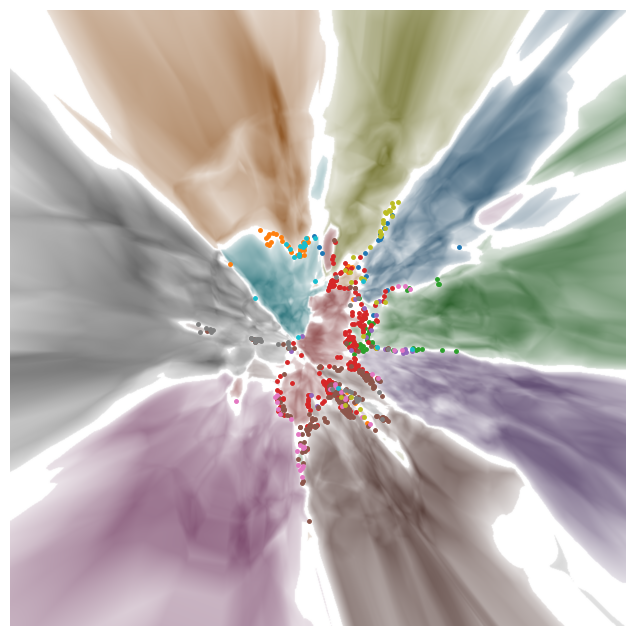

In [142]:
####### target gen boundary
import os

# from representationTrans.visualizer import visualizer
VIS_MODEL_NAME = 'vis'
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

from AlignVis_Visualizer.visualizer_boundary import visualizer
vis = visualizer(ref_provider, ref_all, projector, 800,[all_boundary_list_l],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")

vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img1.png"))

In [165]:
Y = torch.Tensor(tar_all)
encoded_Y = autoencoder.encoder(Y)

embedd1 = projector.batch_project(200,encoded_Y.detach().numpy()[sss])
embedd12 = projector.batch_project(200, ref_all[sss])
num = 0
far = []
import math
for i in range(len(embedd12)):
    if abs(math.fabs(embedd1[i][0] - embedd12[i][0])) > 2:
        print(math.fabs(embedd1[i][0] - embedd12[i][0]))
        num = num + 1
        far.append(sss[i])
len(far)

2.2929553985595703
5.12816047668457
2.5346028804779053
3.6595773696899414
2.1141297817230225
2.0600645542144775
3.291470766067505
2.7267556190490723
3.6574487686157227
3.1732101440429688
2.6436026096343994
5.035436153411865
4.662997245788574
3.6121270656585693
3.109409809112549
2.0711655616760254
5.78642463684082
8.206742286682129
3.1476285457611084
3.1257290840148926
3.197509288787842
5.725895881652832
4.178659915924072
2.304030418395996
3.1967077255249023
3.2606115341186523
2.3404507637023926
2.4920496940612793
4.161509037017822
3.7573468685150146
2.0306684970855713
3.6770944595336914
2.666593551635742
2.0880885124206543
3.062375783920288
3.8348801136016846
2.4789421558380127
4.183657169342041
3.3658347129821777
2.9831557273864746
2.734260320663452
2.443881034851074
3.377302408218384
2.3489320278167725
2.394136667251587
3.011930465698242
2.448915958404541
2.3294286727905273
2.13417649269104
2.9539127349853516
2.853074073791504
2.7513065338134766
3.6772265434265137
2.5662529468536377


493

Computing decision regions ...


100%|██████████| 3200/3200 [00:02<00:00, 1177.96it/s]
../AlignVis_Visualizer/visualizer_boundary.py:188: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  after_trans = self.train_representation[self.indicates]
100%|██████████| 3/3 [00:00<00:00, 8898.81it/s]


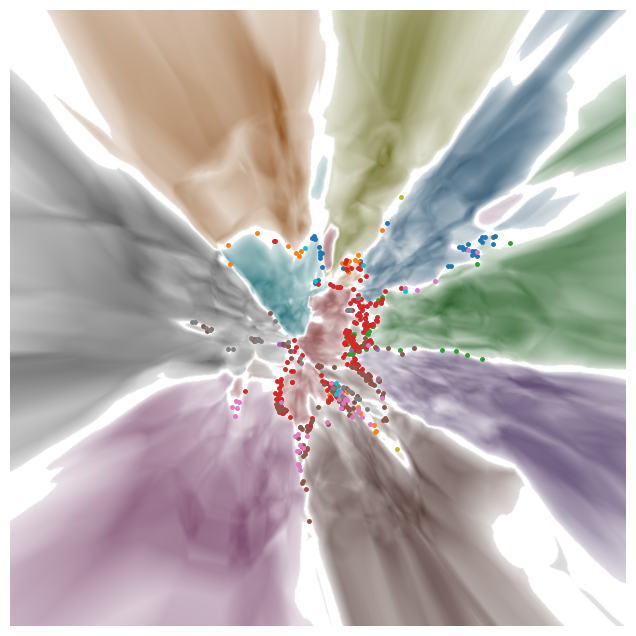

In [167]:
####### target gen boundary
import os

# from representationTrans.visualizer import visualizer
VIS_MODEL_NAME = 'vis'
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

from AlignVis_Visualizer.visualizer_boundary import visualizer
vis = visualizer(ref_provider, ref_all, projector, 800,[far],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")

vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img1.png"))

Computing decision regions ...


100%|██████████| 3200/3200 [00:02<00:00, 1261.70it/s]
../AlignVis_Visualizer/vis_boundary_coder.py:190: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  after_trans = self.train_representation[self.indicates]
100%|██████████| 3/3 [00:00<00:00, 9131.29it/s]


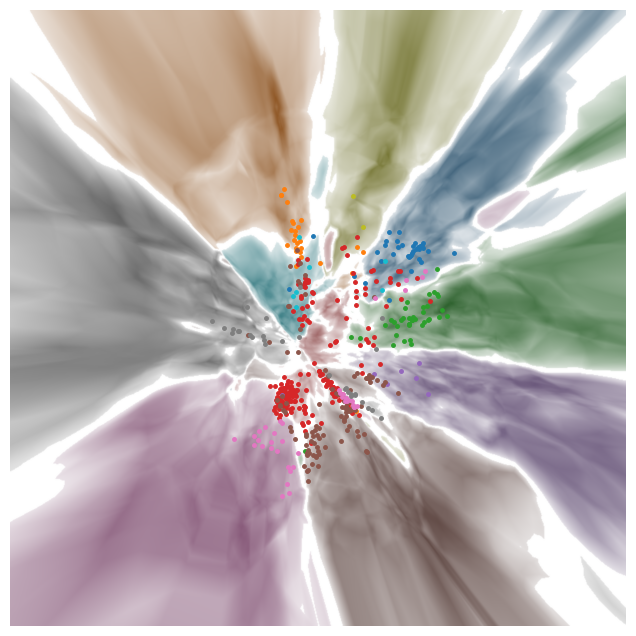

In [168]:
####### target gen boundary
import os

# from representationTrans.visualizer import visualizer
VIS_MODEL_NAME = 'vis'
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
Y = torch.Tensor(tar_all)
encoded_Y = autoencoder.encoder(Y)
from AlignVis_Visualizer.vis_boundary_coder import visualizer
vis = visualizer(ref_provider, tar_provider, encoded_Y.detach().numpy(), projector, autoencoder,800,[far],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")

vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img1.png"))

In [158]:
Y = torch.Tensor(tar_all)
encoded_Y = autoencoder.encoder(Y)

embedd1 = projector.batch_project(200,encoded_Y.detach().numpy()[all_boundary_list_l])
embedd12 = projector.batch_project(200, ref_all[all_boundary_list_l])
num = 0
near = []
import math
for i in range(len(embedd12)):
    if abs(math.fabs(embedd1[i][0] - embedd12[i][0])) < 0.5:
        print(math.fabs(embedd1[i][0] - embedd12[i][0]))
        num = num + 1
        near.append(all_boundary_list_l[i])
print("",num)

0.05935239791870117
0.2969985008239746
0.260007381439209
0.04877972602844238
0.2771635055541992
0.4369211196899414
0.17796683311462402
0.4804253578186035
0.10975027084350586
0.35391688346862793
0.47223925590515137
0.2563283443450928
0.32127058506011963
0.3307039737701416
0.08960355818271637
0.03843379020690918
0.20995044708251953
0.149580717086792
0.0038275718688964844
0.26209187507629395
0.02212059497833252
0.2555654048919678
0.43512964248657227
0.10280394554138184
0.24628639221191406
0.030104517936706543
0.19143414497375488
0.03527820110321045
0.33098459243774414
0.15993714332580566
0.2821321487426758
0.2606327533721924
0.06948494911193848
0.008409380912780762
0.31897634267807007
0.19351375102996826
0.2592811584472656
0.2581172585487366
0.30832910537719727
0.29461002349853516
0.3795499801635742
0.45862865447998047
0.4976797103881836
0.4842594861984253
0.037960171699523926
0.08280539512634277
0.4328286647796631
0.15114402770996094
0.44326603412628174
0.2956508994102478
0.2923256754875

Computing decision regions ...


100%|██████████| 2/2 [00:00<00:00, 4946.11it/s]


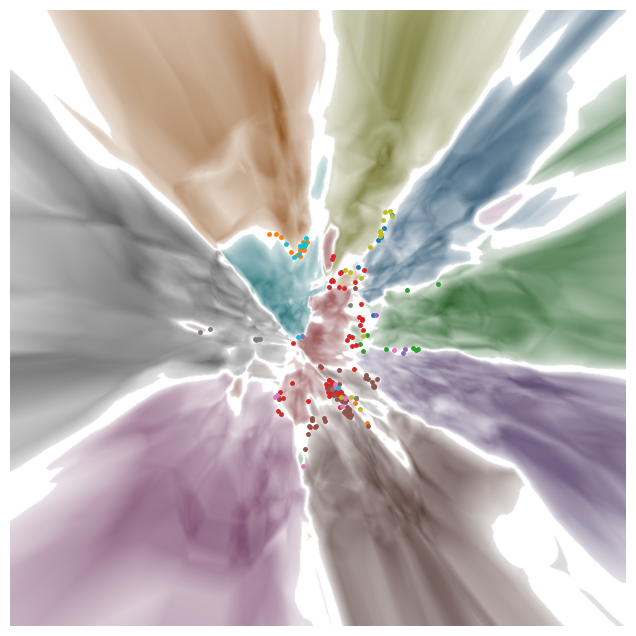

In [161]:
####### target gen boundary
import os

# from representationTrans.visualizer import visualizer
VIS_MODEL_NAME = 'vis'
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

from AlignVis_Visualizer.visualizer_boundary import visualizer
vis = visualizer(ref_provider, ref_all, projector, 800,[near],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")

vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img1.png"))

Computing decision regions ...


100%|██████████| 2/2 [00:00<00:00, 5457.78it/s]


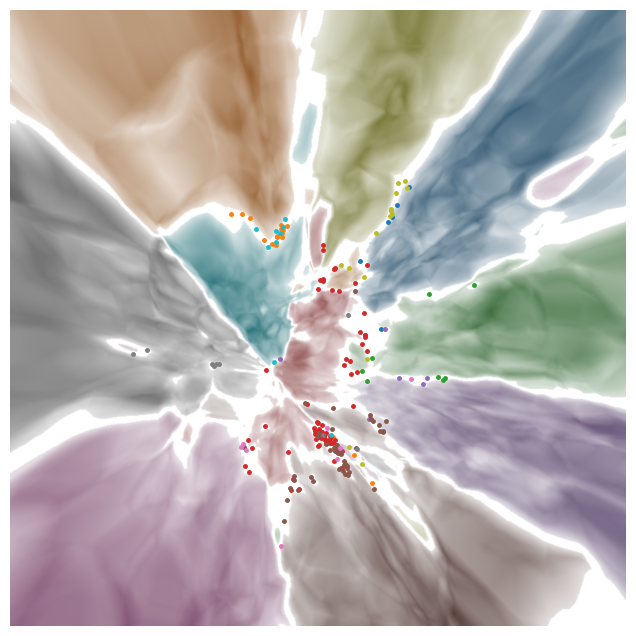

In [163]:
####### target gen boundary
import os

# from representationTrans.visualizer import visualizer
VIS_MODEL_NAME = 'vis'
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

from AlignVis_Visualizer.visualizer_boundary import visualizer
vis = visualizer(ref_provider, ref_all, projector, 800,[near],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")

vis.savefig(10, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img1.png"))

Computing decision regions ...


100%|██████████| 2/2 [00:00<00:00, 5366.99it/s]


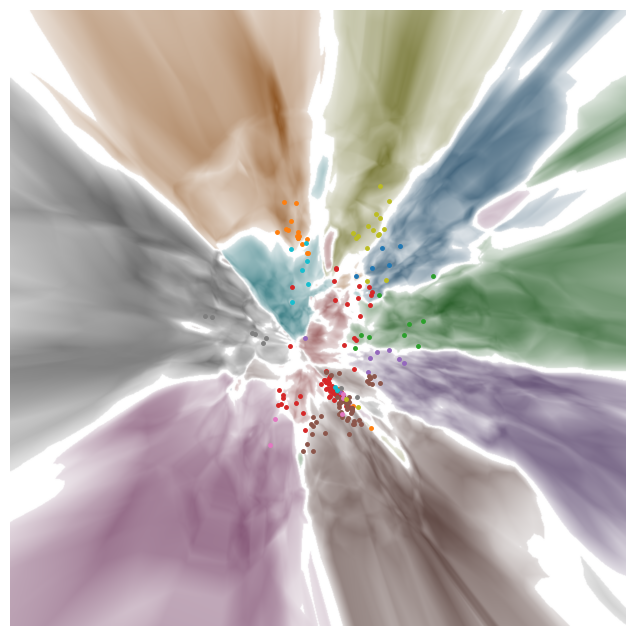

In [164]:
####### target gen boundary
import os

# from representationTrans.visualizer import visualizer
VIS_MODEL_NAME = 'vis'
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
Y = torch.Tensor(tar_all)
encoded_Y = autoencoder.encoder(Y)
from AlignVis_Visualizer.vis_boundary_coder import visualizer
vis = visualizer(ref_provider, tar_provider, encoded_Y.detach().numpy(), projector, autoencoder,800,[near],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")

vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img1.png"))

Computing decision regions ...


100%|██████████| 5/5 [00:00<00:00, 8658.76it/s]


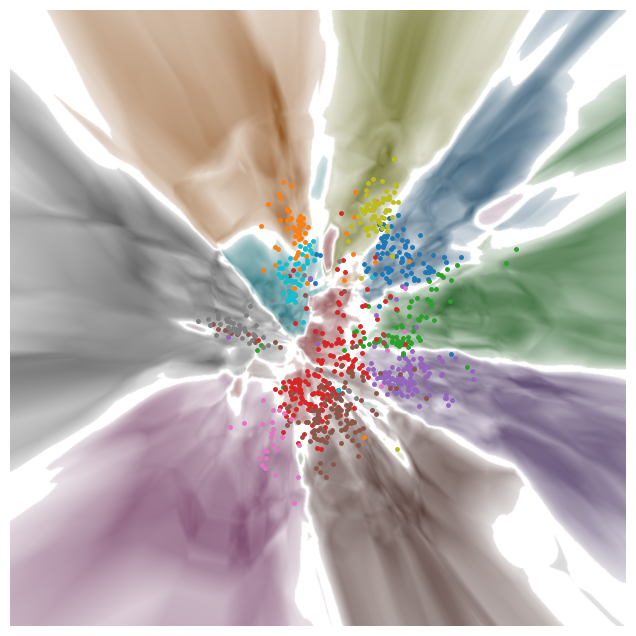

In [137]:
####### target gen boundary
import os

# from representationTrans.visualizer import visualizer
VIS_MODEL_NAME = 'vis'
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

from AlignVis_Visualizer.visualizer_boundary import visualizer
vis = visualizer(ref_provider, ref_all, projector, 800,[all_change],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")

vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img1.png"))

Computing decision regions ...


100%|██████████| 200/200 [00:00<00:00, 8800.75it/s]
../AlignVis_Visualizer/visualizer_boundary.py:188: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  after_trans = self.train_representation[self.indicates]
100%|██████████| 5/5 [00:00<00:00, 10402.54it/s]


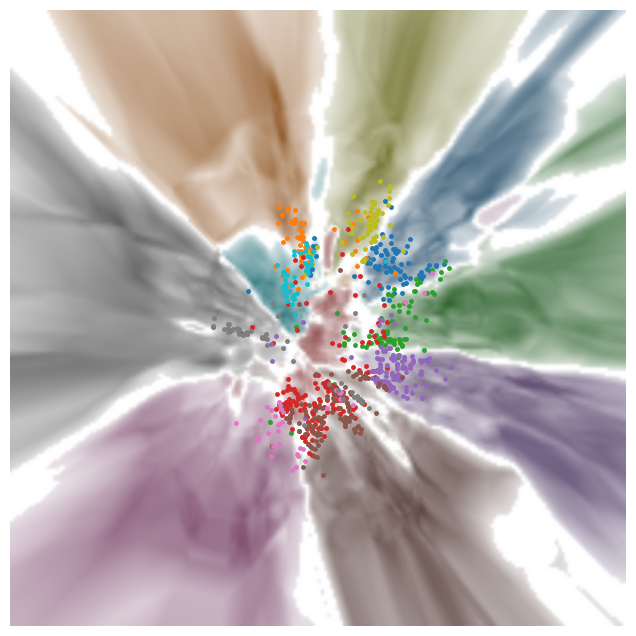

In [135]:
####### target gen boundary
import os

# from representationTrans.visualizer import visualizer
VIS_MODEL_NAME = 'vis'
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
Y = torch.Tensor(tar_all)
encoded_Y = autoencoder.encoder(Y)
from AlignVis_Visualizer.visualizer_boundary import visualizer
vis = visualizer(ref_provider, encoded_Y.detach().numpy(), projector, 200,[all_change],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")

vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img1.png"))

Computing decision regions ...


100%|██████████| 3200/3200 [00:02<00:00, 1311.78it/s]
../AlignVis_Visualizer/visualizer_boundary.py:188: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  after_trans = self.train_representation[self.indicates]
100%|██████████| 3/3 [00:00<00:00, 9052.45it/s]


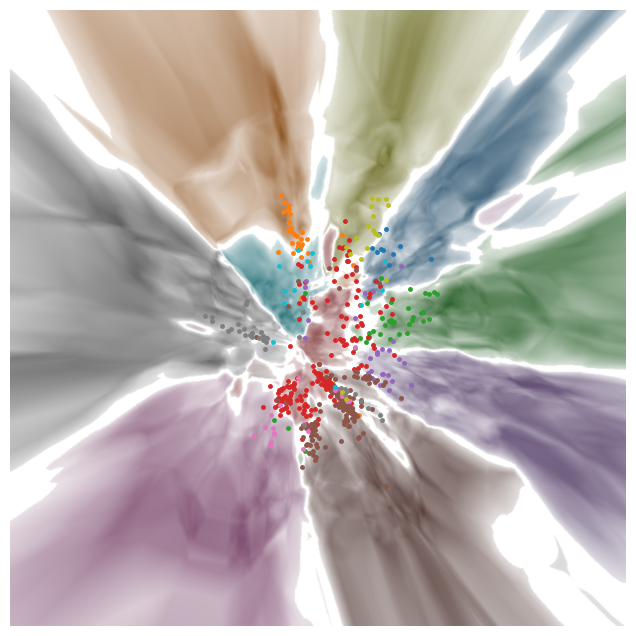

In [121]:
####### target gen boundary
import os

# from representationTrans.visualizer import visualizer
VIS_MODEL_NAME = 'vis'
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
Y = torch.Tensor(tar_all)
encoded_Y = autoencoder.encoder(Y)

from AlignVis_Visualizer.visualizer_boundary import visualizer

vis = visualizer(ref_provider, encoded_Y.detach().numpy(), projector, 800,[all_boundary_list_l],'tab10')
# vis = visualizer(tar_provider, ref_provider, autoencoder, np.dot(encoded_Y.detach().numpy(), I), projector, 200,[all_boundary_list_l],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(REF_EPOCH, path=os.path.join(TAR_PATH, "vis.png"))

Computing decision regions ...


100%|██████████| 200/200 [00:00<00:00, 9327.83it/s]
../AlignVis_Visualizer/visualizer_boundary.py:188: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  after_trans = self.train_representation[self.indicates]
100%|██████████| 2/2 [00:00<00:00, 7281.78it/s]


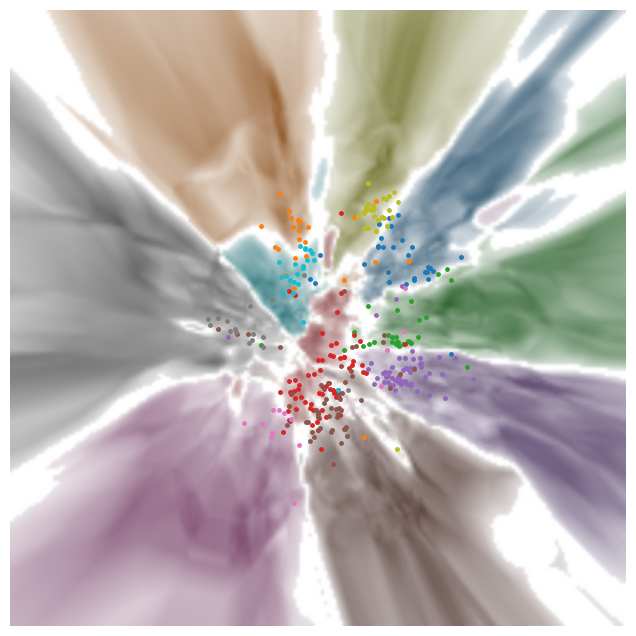

In [33]:
####### target gen boundary
import os

# from representationTrans.visualizer import visualizer
VIS_MODEL_NAME = 'vis'
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

from AlignVis_Visualizer.visualizer_boundary import visualizer
vis = visualizer(ref_provider, ref_train_data, projector, 200,[all_change_l],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")

vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img1.png"))

Computing decision regions ...


100%|██████████| 1/1 [00:00<00:00, 5405.03it/s]


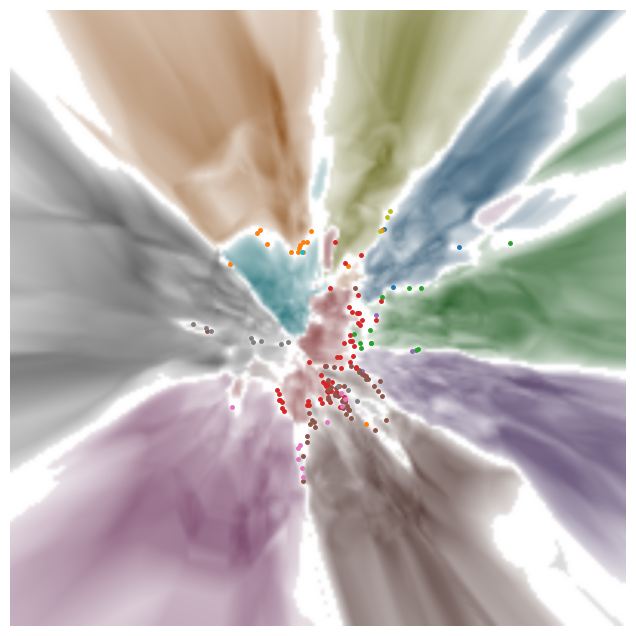

In [74]:
####### target gen boundary
import os

# from representationTrans.visualizer import visualizer
VIS_MODEL_NAME = 'vis'
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

from AlignVis_Visualizer.visualizer_boundary import visualizer
vis = visualizer(ref_provider, ref_train_data, projector, 200,[same_boundary],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")

vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img1.png"))

In [79]:
Y = torch.Tensor(tar_all)
encoded_Y = autoencoder.encoder(Y)

embedd1 = projector.batch_project(200,encoded_Y.detach().numpy()[all_boundary_list_l])

In [98]:
Y = torch.Tensor(tar_all)
encoded_Y = autoencoder.encoder(Y)

embedd1 = projector.batch_project(200,encoded_Y.detach().numpy()[all_boundary_list_l])
embedd12 = projector.batch_project(200, ref_all[all_boundary_list_l])
num = 0
near = []
import math
for i in range(len(embedd12)):
    if abs(math.fabs(embedd1[i][0] - embedd12[i][0])) < 0.05:
        print(math.fabs(embedd1[i][0] - embedd12[i][0]))
        num = num + 1
        near.append(all_boundary_list_l[i])

In [102]:
len(embedd12)

552

In [116]:
num = 0
near = []
import math
for i in range(len(embedd12)):
    if abs(math.fabs(embedd1[i][0] - embedd12[i][0])) < 0.05:
        print(math.fabs(embedd1[i][0] - embedd12[i][0]))
        num = num + 1
        near.append(all_boundary_list_l[i])

0.040329933166503906
0.0455777645111084
0.03415560722351074
0.020268559455871582
0.0342559814453125
0.041790783405303955
0.03281623125076294
0.0433344841003418
0.0015712976455688477
0.016915321350097656
0.006602048873901367
0.027028799057006836
0.04281783103942871
0.01918482780456543


In [115]:
num

14

Computing decision regions ...


100%|██████████| 200/200 [00:00<00:00, 9191.69it/s]
../AlignVis_Visualizer/visualizer.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_data = self.data_provider.train_representation(epoch)[self.indicates]


IndexError: index 50948 is out of bounds for axis 0 with size 50000

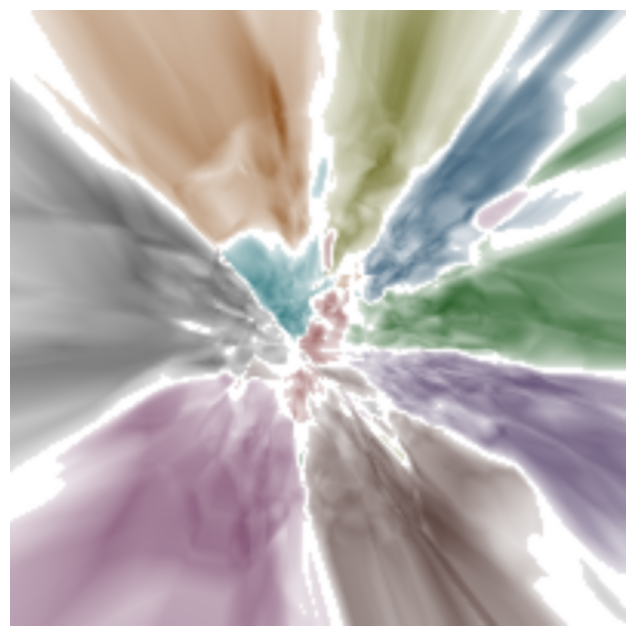

In [120]:
##### visuallize all data
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
VIS_MODEL_NAME = 'baseline'
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
Y = torch.Tensor(tar_all)
encoded_Y = autoencoder.encoder(Y)
I = np.eye(512)
from AlignVis_Visualizer.visualizer import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, ref_provider, autoencoder, np.dot(encoded_Y.detach().numpy(), I), projector, 200,[near],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(REF_EPOCH, path=os.path.join(TAR_PATH, "vis.png"))

Computing decision regions ...


100%|██████████| 200/200 [00:00<00:00, 9422.23it/s]
../AlignVis_Visualizer/visualizer.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_data = self.data_provider.train_representation(epoch)[self.indicates]
../AlignVis_Visualizer/visualizer.py:192: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_labels = self.data_provider.train_labels(epoch)[self.indicates]
../AlignVis_Visualizer/visualizer.py:193: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq

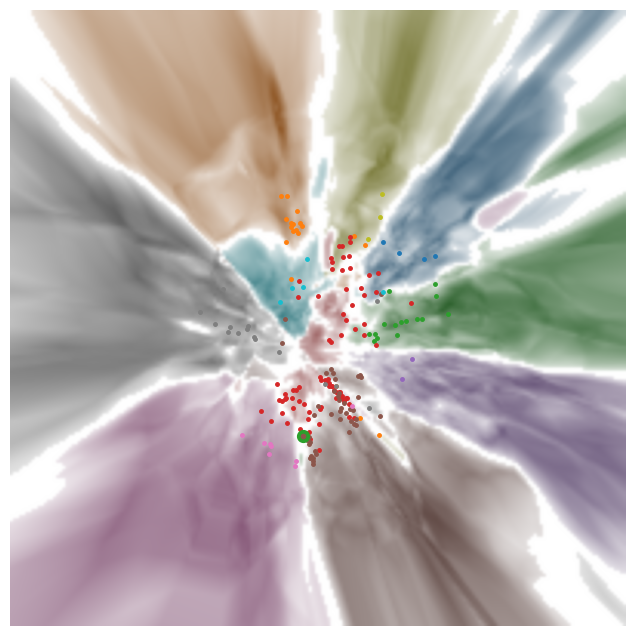

In [41]:
##### visuallize all data
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
VIS_MODEL_NAME = 'baseline'
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
Y = torch.Tensor(tar_provider.train_representation(TAR_EPOCH))
encoded_Y = autoencoder.encoder(Y)
I = np.eye(512)
from AlignVis_Visualizer.visualizer import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, ref_provider, autoencoder, np.dot(encoded_Y.detach().numpy(), I), projector, 200,[diff_boundary],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(REF_EPOCH, path=os.path.join(TAR_PATH, "vis.png"))

In [35]:
eval.eval_ppr_autoencoder(autoencoder)

100%|██████████| 250/250 [00:00<00:00, 8591.58it/s]

#train# autoencoder PPR: 0.94 in epoch 200


0.94178

Computing decision regions ...


100%|██████████| 1/1 [00:00<00:00, 5275.85it/s]


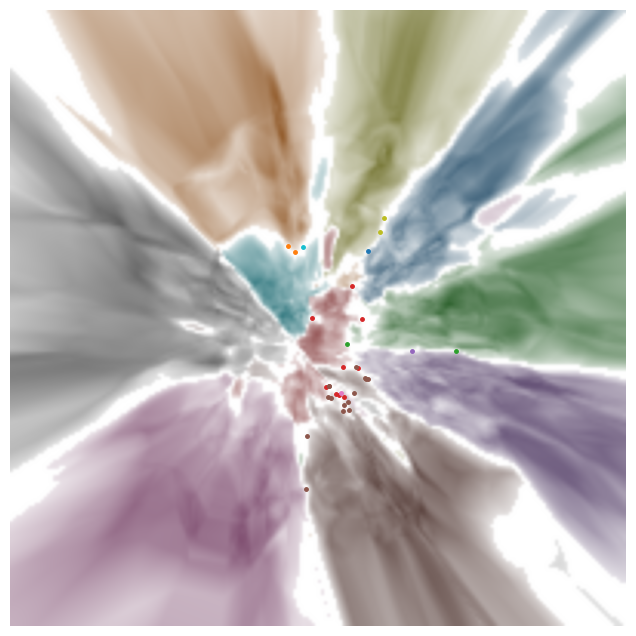

In [18]:
####### target gen boundary
import os

# from representationTrans.visualizer import visualizer
VIS_MODEL_NAME = 'vis'
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

from AlignVis_Visualizer.visualizer_boundary import visualizer
vis = visualizer(ref_provider, ref_train_data, projector, 200,[same_boundary],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")

vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img1.png"))

Computing decision regions ...


100%|██████████| 200/200 [00:00<00:00, 9488.52it/s]
../AlignVis_Visualizer/visualizer.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_data = self.data_provider.train_representation(epoch)[self.indicates]
../AlignVis_Visualizer/visualizer.py:192: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_labels = self.data_provider.train_labels(epoch)[self.indicates]
../AlignVis_Visualizer/visualizer.py:193: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq

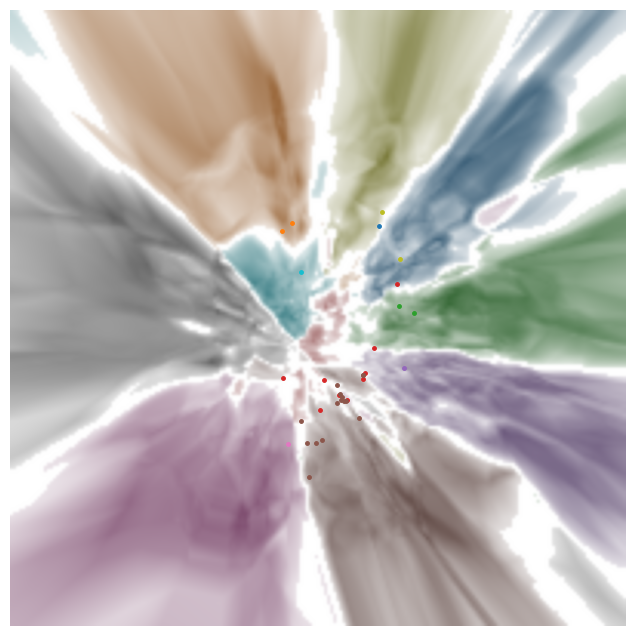

In [19]:
##### visuallize all data
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
VIS_MODEL_NAME = 'baseline'
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
Y = torch.Tensor(tar_provider.train_representation(TAR_EPOCH))
encoded_Y = autoencoder.encoder(Y)
I = np.eye(512)
from AlignVis_Visualizer.visualizer import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, ref_provider, autoencoder, np.dot(encoded_Y.detach().numpy(), I), projector, 200,[same_boundary],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(REF_EPOCH, path=os.path.join(TAR_PATH, "vis.png"))

Computing decision regions ...


100%|██████████| 1/1 [00:00<00:00, 5269.23it/s]


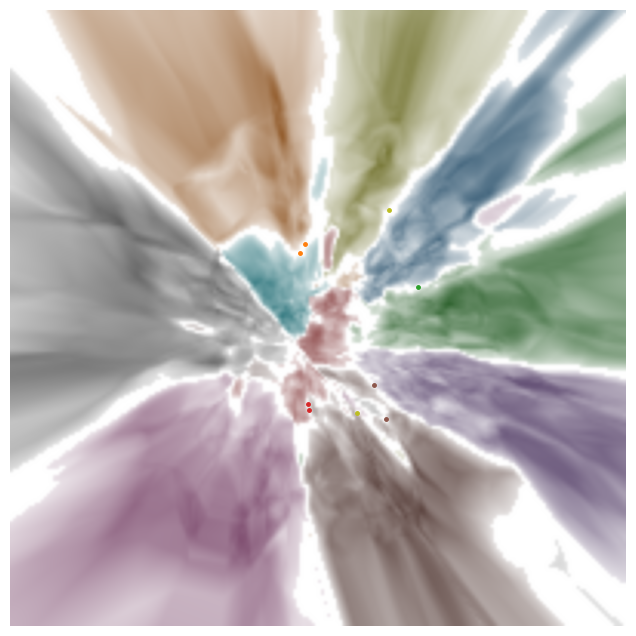

In [67]:
####### target gen boundary
import os

# from representationTrans.visualizer import visualizer
VIS_MODEL_NAME = 'vis'
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

from AlignVis_Visualizer.visualizer_boundary import visualizer
vis = visualizer(ref_provider, ref_train_data, projector, 200,[diff_boundary],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")

vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img1.png"))

Computing decision regions ...


100%|██████████| 1/1 [00:00<00:00, 5562.74it/s]


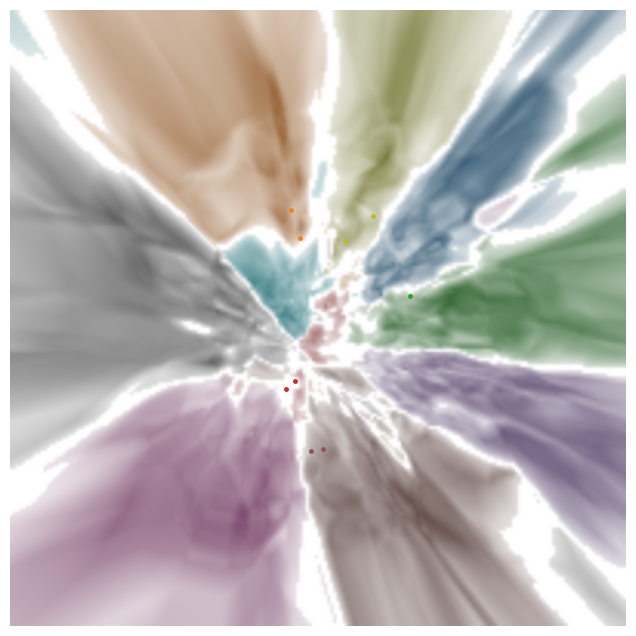

In [68]:
##### visuallize all data
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
VIS_MODEL_NAME = 'vis'
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
Y = torch.Tensor(tar_provider.train_representation(TAR_EPOCH))
encoded_Y = autoencoder.encoder(Y)
I = np.eye(512)
from AlignVis_Visualizer.visualizer import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, ref_provider, autoencoder, np.dot(encoded_Y.detach().numpy(), I), projector, 200,[diff_boundary],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(REF_EPOCH, path=os.path.join(TAR_PATH, "vis.png"))

Computing decision regions ...


100%|██████████| 200/200 [00:00<00:00, 9117.16it/s]
../AlignVis_Visualizer/visualizer_boundary.py:187: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  after_trans = self.train_representation[self.indicates]
100%|██████████| 1/1 [00:00<00:00, 4076.10it/s]


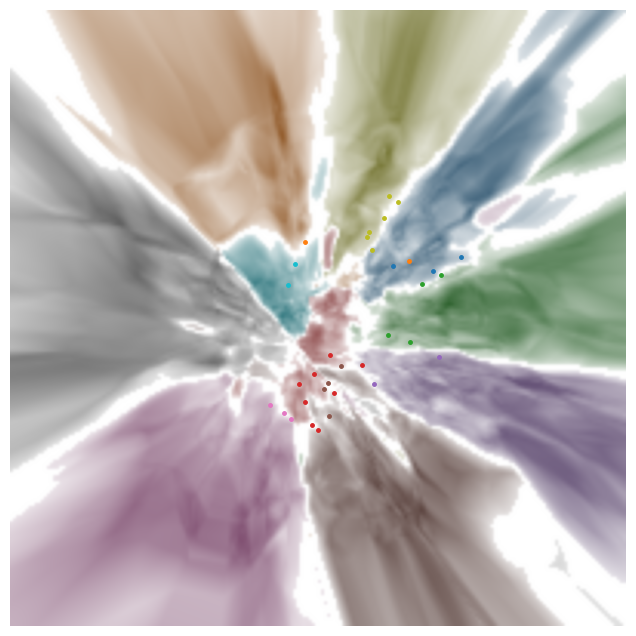

In [52]:
####### target gen boundary
import os

# from representationTrans.visualizer import visualizer
VIS_MODEL_NAME = 'vis'
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")


from AlignVis_Visualizer.visualizer_boundary import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, ref_train_data, projector, 200,[same_boundary],'tab10')
# from representationTrans.visualizer import visualizer
# vis = visualizer(tar_provider, I,I, np.dot(tar_provider.test_representation(200), I), projector, 200,[predict_label_diff_indicates],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img1.png"))